# Parsing Events from Raw Data

Concepts covered : 
- how to read experimental events from raw recordings
- how to convert between the two different representations of events within MNE-Python (Events arrays and Annotations objects)


In [2]:
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax = 60).load_data()



Opening raw data file /Users/qbit-glitch/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MiB, data loaded>

## Events and Annotations Datastructures

Both the Events and Annotations data structures serve the same purpose: they provide a mapping between times during an EEG/MEG recording and a description of what happened at those times. In other words, they associate a when with a what. 

Main Differences : 

- Units: the Events data structure represents the when in terms of samples, whereas the Annotations data structure represents the when in seconds.

- Limits on the description: the Events data structure represents the what as an integer “Event ID” code, whereas the Annotations data structure represents the what as a string.

- How duration is encoded: Events in an Event array do not have a duration (though it is possible to represent duration with pairs of onset/offset events within an Events array), whereas each element of an Annotations object necessarily includes a duration (though the duration can be zero if an instantaneous event is desired).

- Internal representation: Events are stored as an ordinary NumPy array, whereas Annotations is a list-like class defined in MNE-Python.



## What is a STIM Channel ?

STIM Channels record voltages that are time-locked to experimental events, such as the onset of a stimulus or a button-press response by the subject (those pulse are sometimes called TTL pulses, event pulses, trigger signals or just 'triggers'). In other cases, pulses may not be strictly time-locked to an experimental event, but instead may occur in between trials to indicate the type of stimulus (or experimental condition) that is about to occur on the upcomming trial.

The DV pulses maybe all on one STIM channel or they may be spread accross several channels. On systems with multiple STIM channels, there is often one channel that records a weighted sum of the other STIM channels, in such a way that voltage levels on that channels can be unambiguously decoded as particular event types.

Using matplotlib as 2D backend.


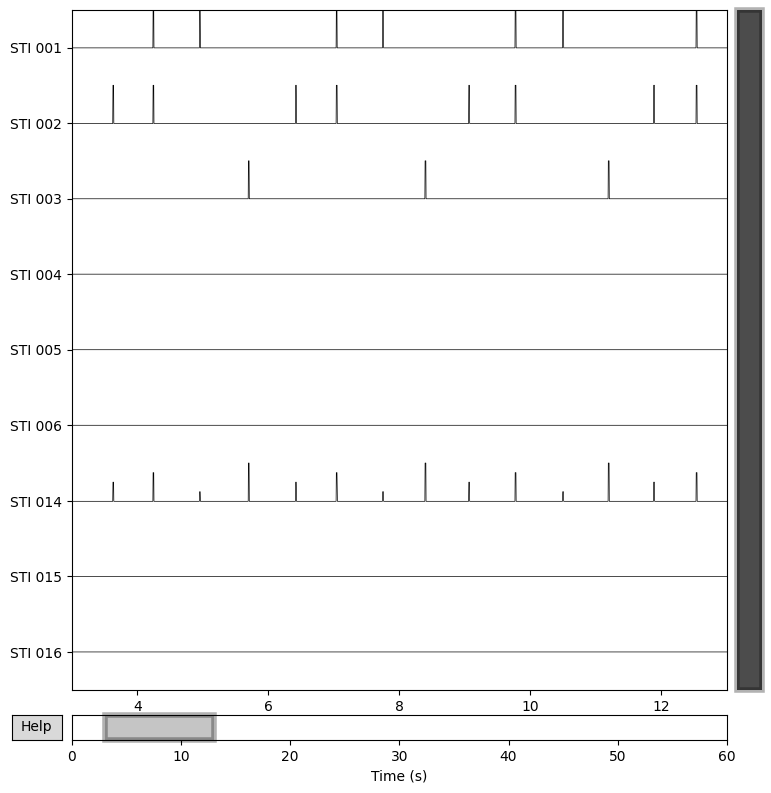

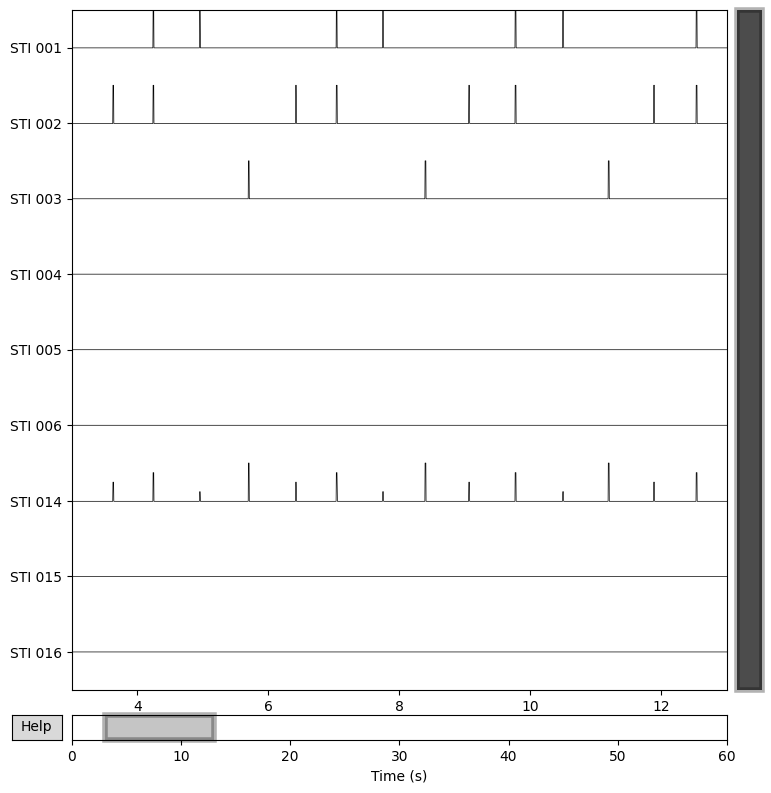

In [3]:
raw.copy().pick(picks='stim').plot(start=3, duration=10)

`STI 014` contains the weighted sum of all other pulses.

## Converting a STIM channel signal to an Events array

Convert events recorded on STIM channesl into an Events array using `find_events`. The sample number of the onset(or offset) of each pulse is recorded as the event time, the pulse magnitudes are converted into integers and these paris of sample numbers plus integer codes are stored in `Numpy_arrays` (usually called events array).

The function only requires the Raw object, and the name of the channel from which to read events.

In [5]:
events = mne.find_events(raw, stim_channel = 'STI 014')
print(events.shape)

Finding events on: STI 014
86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
(86, 3)


If you don’t provide the name of a STIM channel, find_events will first look for MNE-Python config variables for variables MNE_STIM_CHANNEL, MNE_STIM_CHANNEL_1, etc. If those are not found, channels STI 014 and STI101 are tried, followed by the first channel with type “STIM” present in raw.ch_names. If you regularly work with data from several different MEG systems with different STIM channel names, setting the MNE_STIM_CHANNEL config variable may not be very useful, but for researchers whose data is all from a single system it can be a time-saver to configure that variable once and then forget about it.



## Reading embedded events as Annotations

Some EEG/MEG systems generate files where events are stored in a separate data array rather than as pulses on one or more STIM channels. For example, the EEGLAB format stores events as a collection of arrays in the .set file. When reading those files, MNE-Python will automatically convert the stored events into an Annotations object and store it as the annotations attribute of the Raw object:

In [6]:
testing_data_folder = mne.datasets.testing.data_path()
eeglab_raw_file = testing_data_folder/'EEGLAB'/'test_raw.set'
eeglab_raw = mne.io.read_raw_eeglab(eeglab_raw_file)
print(eeglab_raw.annotations)


Using default location ~/mne_data for testing...
Dataset testing version 0.0 out of date, latest version is 0.161


0.00B [00:00, ?B/s]     
Untarring contents of '/Users/qbit-glitch/mne_data/mne-testing-data-0.161.tar.gz' to '/Users/qbit-glitch/mne_data'


Download complete in 02m03s (1047.5 MB)
Reading /Users/qbit-glitch/mne_data/MNE-testing-data/EEGLAB/test_raw.fdt
<Annotations | 154 segments: rt (74), square (80)>


the core data in annotations objects is accessible through three of its attributes : `onset`, `duration`, `description`. 

In [7]:
print(len(eeglab_raw.annotations))
print(set(eeglab_raw.annotations.duration))
print(set(eeglab_raw.annotations.description))
print(eeglab_raw.annotations.onset[0])

154
{np.float64(0.0)}
{np.str_('rt'), np.str_('square')}
1.000068


[`Annotations` Object](https://mne.tools/stable/generated/mne.Annotations.html#mne.Annotations)

## Converting between Events arrays and Annotations objects

an Events array is needed for epoching continuous data, or because you want to take advantage of the “annotation-aware” capability of some functions, which automatically omit spans of data if they overlap with certain annotations.

Annotations to Events objects : use `mne.events_from_annotations` on the raw file containing the annotations.

By default, one event will be created at the onset of each annotations; this can be modified via the `chunk_duration` parameter of `events_from_annotations` to create equally spaced events within each annotation span. Reference: [Making Multiple events from annotation](https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html#chunk-duration) or [Making Equally spaced Events arrays](https://mne.tools/stable/auto_tutorials/raw/20_event_arrays.html#fixed-length-events)

In [8]:
events_from_annot, event_dict = mne.events_from_annotations(eeglab_raw)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: [np.str_('rt'), np.str_('square')]
{np.str_('rt'): 1, np.str_('square'): 2}
[[128   0   2]
 [217   0   2]
 [267   0   1]
 [602   0   2]
 [659   0   1]]


If you want to control which integers are mapped to each unique description value, you can pass a dict specifying the mapping as the event_id parameter of events_from_annotations; this dict will be returned unmodified as the event_dict.

Note that this `event_dict` can be used when creating [`Epochs`](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) from Raw objects.

In [9]:
custom_mapping = {'rt':77, 'square':42}
(events_from_annot, event_dict) = mne.events_from_annotations(
    eeglab_raw, event_id=custom_mapping
)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: [np.str_('rt'), np.str_('square')]
{np.str_('rt'): 77, np.str_('square'): 42}
[[128   0  42]
 [217   0  42]
 [267   0  77]
 [602   0  42]
 [659   0  77]]


### Conversion: Events array to Annotations object

use `annotations_from_events` to construct `Annotations` object and call the `set_annotations` method to add annotations to the Raw object.

Because the sample_data wal recorded on a Neuromag system(where sample numbering starts when the acquisition system is initiated, not when the recoding is initiated), we also need to pass in the orig_tim parameter so that the onsets are properly aligned relative to the start of recording.


In [10]:
mapping = {
    1: 'auditory/left',
    2: 'auditory/right',
    3: 'visual/left',
    4: 'visual/right',
    5: 'smiley',
    32: 'buttonpress'
}

annot_from_events = mne.annotations_from_events(
    events = events,
    event_desc = mapping,
    sfreq = raw.info['sfreq'],
    orig_time = raw.info['meas_date']
)

raw.set_annotations(annot_from_events)

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MiB, data loaded>

/Users/qbit-glitch/Desktop/coding-projects/eeg_signal_processing/venv_2/lib/python3.10/site-packages/mne/viz/_figure.py:380: RuntimeWarning: divide by zero encountered in matmul
  data = self.mne.projector @ data
/Users/qbit-glitch/Desktop/coding-projects/eeg_signal_processing/venv_2/lib/python3.10/site-packages/mne/viz/_figure.py:380: RuntimeWarning: overflow encountered in matmul
  data = self.mne.projector @ data
/Users/qbit-glitch/Desktop/coding-projects/eeg_signal_processing/venv_2/lib/python3.10/site-packages/mne/viz/_figure.py:380: RuntimeWarning: invalid value encountered in matmul
  data = self.mne.projector @ data


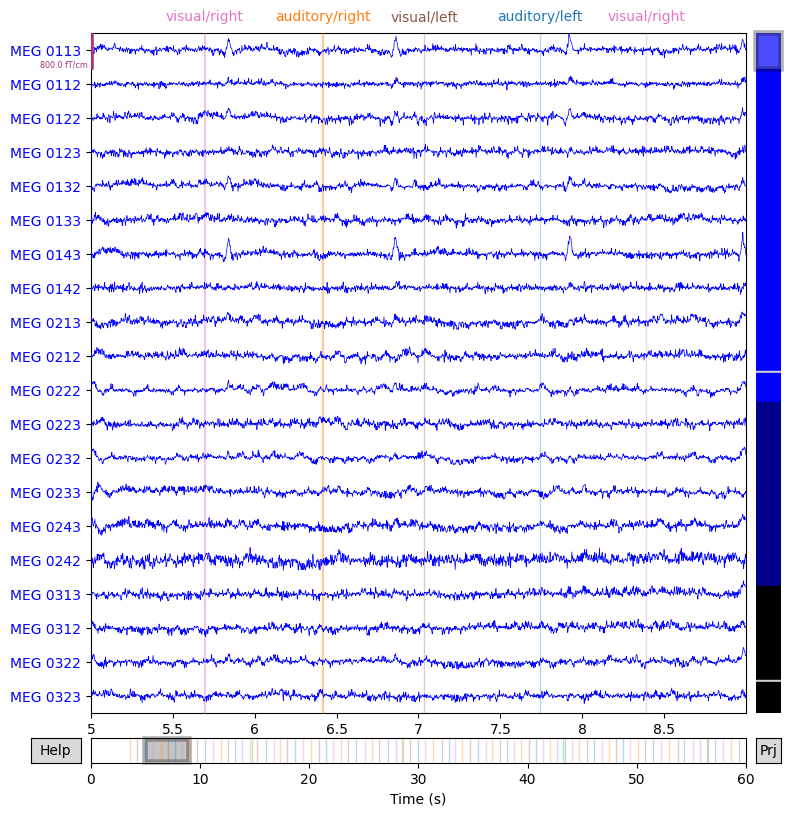

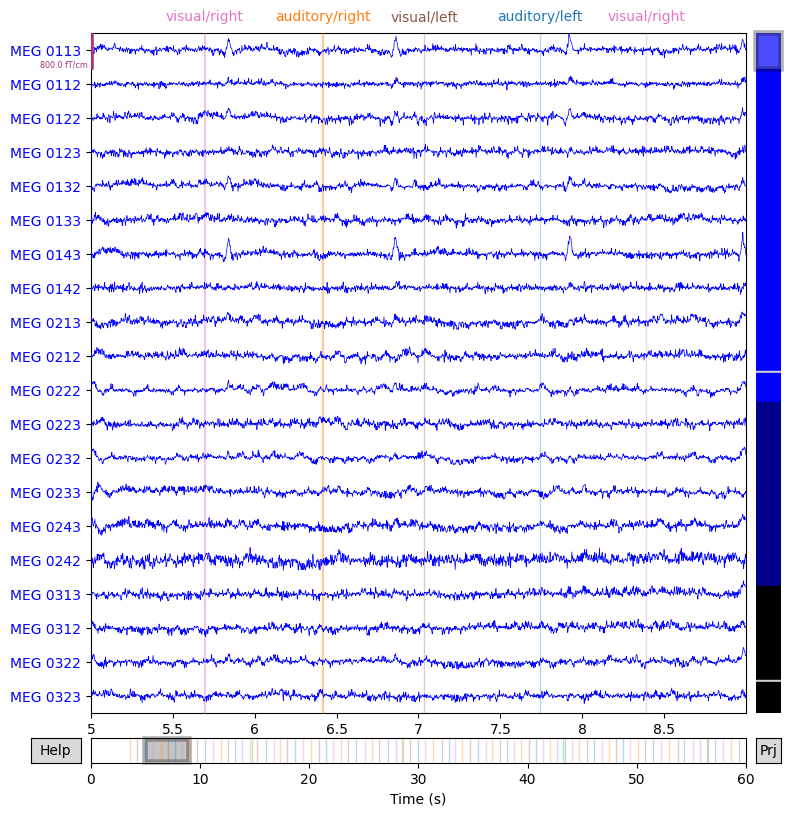

In [12]:
raw.plot(start=5, duration=4)

## Making multiple events per annotations

We can generate equally spaced events from an `Annotations` object using the `chunk_duration` parameter of `events_from_annotations`.

For example, suppose we have an annotation in our Raw object indicating when the subject was in REM sleep, and we want to perform a resting-state analysis on those spans of data. We can create an Events array with a series of equally-spaced events within each “REM” span, and then use those events to generate (potentially overlapping) epochs that we can analyze further.


In [13]:
# create the REM annotations
rem_annot = mne.Annotations(onset=[5,41], duration=[16,11], description=['REM'] * 2)
raw.set_annotations(rem_annot)
(rem_events, rem_event_dict) = mne.events_from_annotations(raw, chunk_duration=1.5)


Used Annotations descriptions: [np.str_('REM')]


In [14]:
print(np.round((rem_events[:,0] - raw.first_samp) / raw.info['sfreq'], 3))

[ 5.     6.5    8.     9.5   11.    12.501 14.001 15.501 16.999 18.499
 41.    42.5   44.    45.5   47.    48.5   50.   ]
